In [1]:
import os, sys
import torch
import numpy as np
import scipy as sp
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torch.optim as optim

import matplotlib.pyplot as plt

We start by codeing the first derivative matrix. A finite difference matrix from the
nodes to the cell centers.
$$ (Du)_{i+1/2} = {\frac 1h} (u_{i+1} - u_i) $$

In [2]:
def DxNodeToCell(h, n):

  diagonals = [-np.ones(n+1)/h, np.ones(n+1)/h]
  Dx = sparse.spdiags(diagonals, [0, 1], n,n+1)
  return Dx


We now test the code on a simple function

h =  0.125 average error =  0.10468861190812412
h =  0.0625 average error =  0.025818171198255746
h =  0.03125 average error =  0.006432756335899705
h =  0.015625 average error =  0.0016068326198611814
h =  0.0078125 average error =  0.00040162345673459246
h =  0.00390625 average error =  0.00010040057180516181


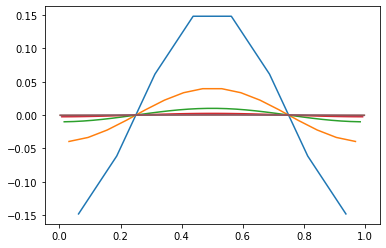

In [3]:
for i in range(6):
  n = 2**(i+3)
  h = 1.0/n
  # nodal grid
  x = np.linspace(0, n, n+1)*h
  
  # cell centered grid
  xc = x[:-1] + h/2 

  u = np.sin(2*np.pi*x)
  D = DxNodeToCell(h,n)

  up = D@u
  up_true = 2*np.pi*np.cos(2*np.pi*xc)

  r = up-up_true
  print('h = ',h, 'average error = ',np.absolute(r).mean())
  plt.plot(xc, r)


Next we code a finite difference matrix from the cells to the nodes

In [4]:
# Note the boundary condition
#                           (uG - un)/h
# x ---0---x---0---x ---0 ---x---G
# but uG = -un

def DxCellToNode(h, n):

  d1 = -np.ones(n)/h
  d1[-1] = -2/h
  d2 = np.ones(n)/h
  d2[0] = 2/h
  diagonals = [d1, d2]
  Dx = sp.sparse.spdiags(diagonals, [-1, 0], n+1,n)
  
  return Dx

In [5]:
A = DxCellToNode(1, 5).toarray()
print(A)

[[ 2.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.]
 [ 0.  0. -1.  1.  0.]
 [ 0.  0.  0. -1.  1.]
 [ 0.  0.  0.  0. -2.]]


h =  0.125 average error =  0.10377863510773433
h =  0.0625 average error =  0.026202842300844666
h =  0.03125 average error =  0.006513494347764476
h =  0.015625 average error =  0.001619021675760613
h =  0.0078125 average error =  0.000403280036488708
h =  0.00390625 average error =  0.000100616015246868


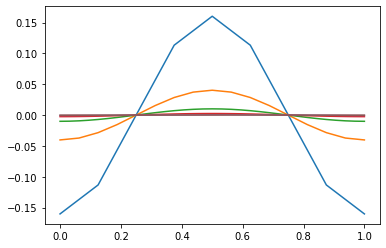

In [6]:
# Testing - note boundary conditions!!!

for i in range(6):
  n = 2**(i+3)
  h = 1.0/n
  # nodal grid
  x = np.linspace(0, n, n+1)*h
  # cell centered grid
  xc = x[:-1] + h/2 

  u = np.sin(2*np.pi*xc)
  D = DxCellToNode(h, n)

  up = D@u
  up_true = 2*np.pi*np.cos(2*np.pi*x)

  r = up-up_true
  print('h = ',h, 'average error = ',np.absolute(r).mean())
  plt.plot(x, r)


In [7]:
# Mass matrix
def getMassMatrix(sig):
  n = len(sig)
  M = sp.sparse.spdiags(sig, 0, n,n)
  
  return M

In [42]:
# Now lets put it all together and test it
# We experiment with the functions
# p(x) = a(x)*cos(2*pi*x)
# dp/dx = a(x)'*cos(2*pi*x) - a(x)*sin(x)
# J(x) = 2*pi*sigma(x)*a(x)'*cos(x) - 2*pi*sigma(x)*a(x)*sin(x)
# Choose a(x) such the BC for J work
# a(x) = x**2/2 - x**3/3 => a'(x) = x - x^2
# Now q(x) = dJ/dx = 

def afun(x):
  a = x**2/2 - x**3/3
  ap = x - x**2
  return a, ap
def pfun(x):
  pi = np.pi
  a, ap = afun(x)
  p = a*np.cos(2*pi*x)
  px = ap*np.cos(2*pi*x) - a*np.sin(x)
  return p, px
def sigfun(x, n):
  return 2 + np.sin(n*np.pi*x)
def jfun(x):
  p, px = pfun(x)
  sig = sigfun(x)
  J = sig*px
  return J

def qfun(x, n):
  pi = np.pi
  sin = np.sin
  cos = np.cos
  
  q = (sin(n*pi*x) + 2)*(cos(2*pi*x) - 2*x*cos(2*pi*x) + 4*x**2*pi*sin(2*pi*x) - 2*x**2*pi**2*cos(2*pi*x) + (4*x**3*pi**2*cos(2*pi*x))/3 - 4*x*pi*sin(2*pi*x)) - n*pi*cos(n*pi*x)*(x*cos(2*pi*x)*(x - 1) - (x**2*pi*sin(2*pi*x)*(2*x - 3))/3)
 
  return q


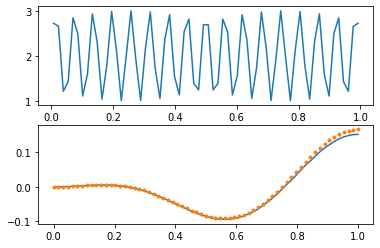

In [47]:

kk = 33
for j in range(4):
  n = 2**(3+j)
  h = 1/n
  # nodal grid
  x = np.linspace(0, n, n+1)*h
  # cell centered grid
  xc = x[:-1] + h/2 

  # Periodic media
  sig = sigfun(xc, kk)
  
  Dnc = DxNodeToCell(h, n)
  Dcn = DxCellToNode(h, n)
  M   = getMassMatrix(sig)

  # Combine matrices
  A = Dcn@(M@Dnc) + 1e-2*sparse.eye(n+1)

  # define a source on the nodes
  q = qfun(x, kk)

  from scipy.sparse.linalg import spsolve
  u = spsolve(A, q)
  utrue, uptrue = pfun(x)
  u = u-u[0]+utrue[0]

utrue, uptrue = pfun(x)
plt.subplot(2,1,1)
plt.plot(xc, sig)
plt.subplot(2,1,2)
plt.plot(x, u)
plt.plot(x, utrue,'.')



In [23]:
exp = np.exp
exp(1.0)

2.718281828459045